In [2]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import math

In [3]:
# Load the dataset
churn_data = pd.read_csv('../files/raw_BankChurners.csv')
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                           

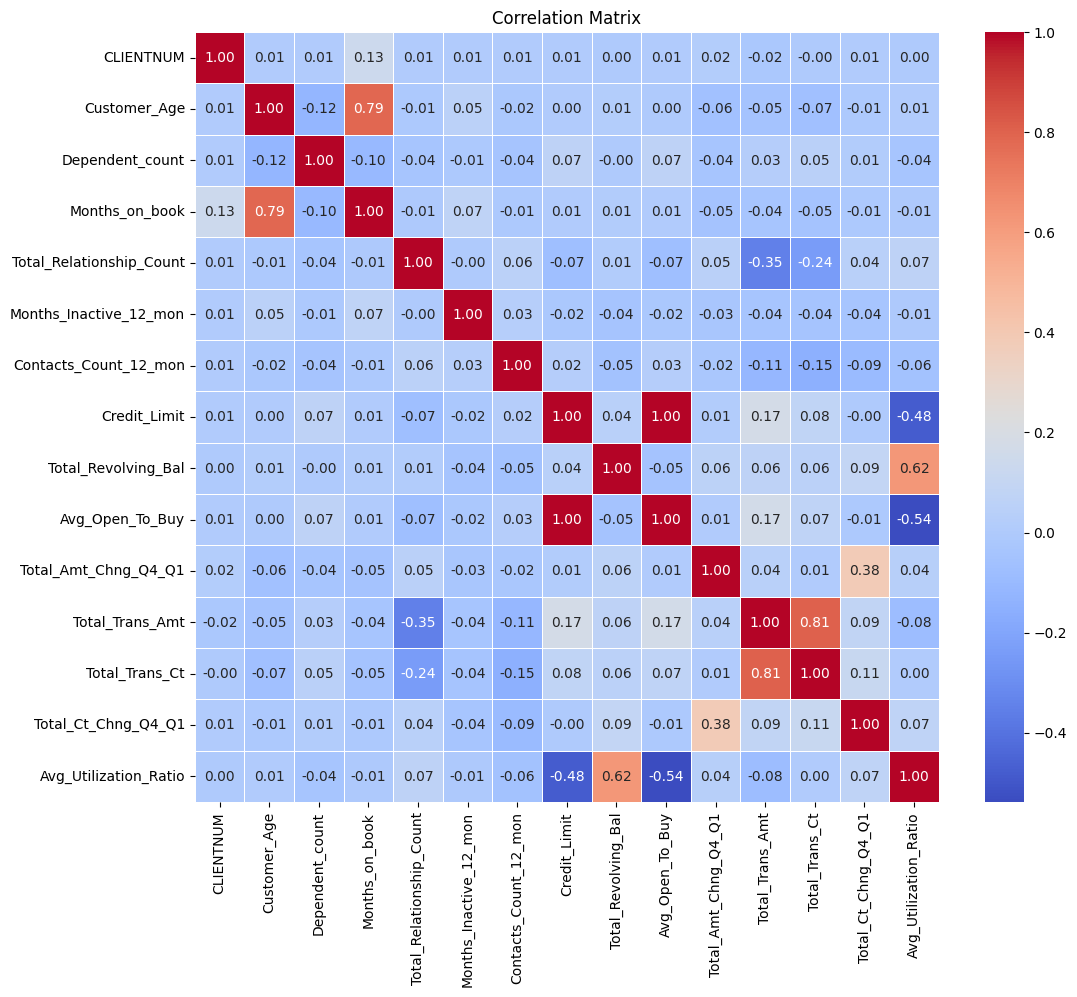

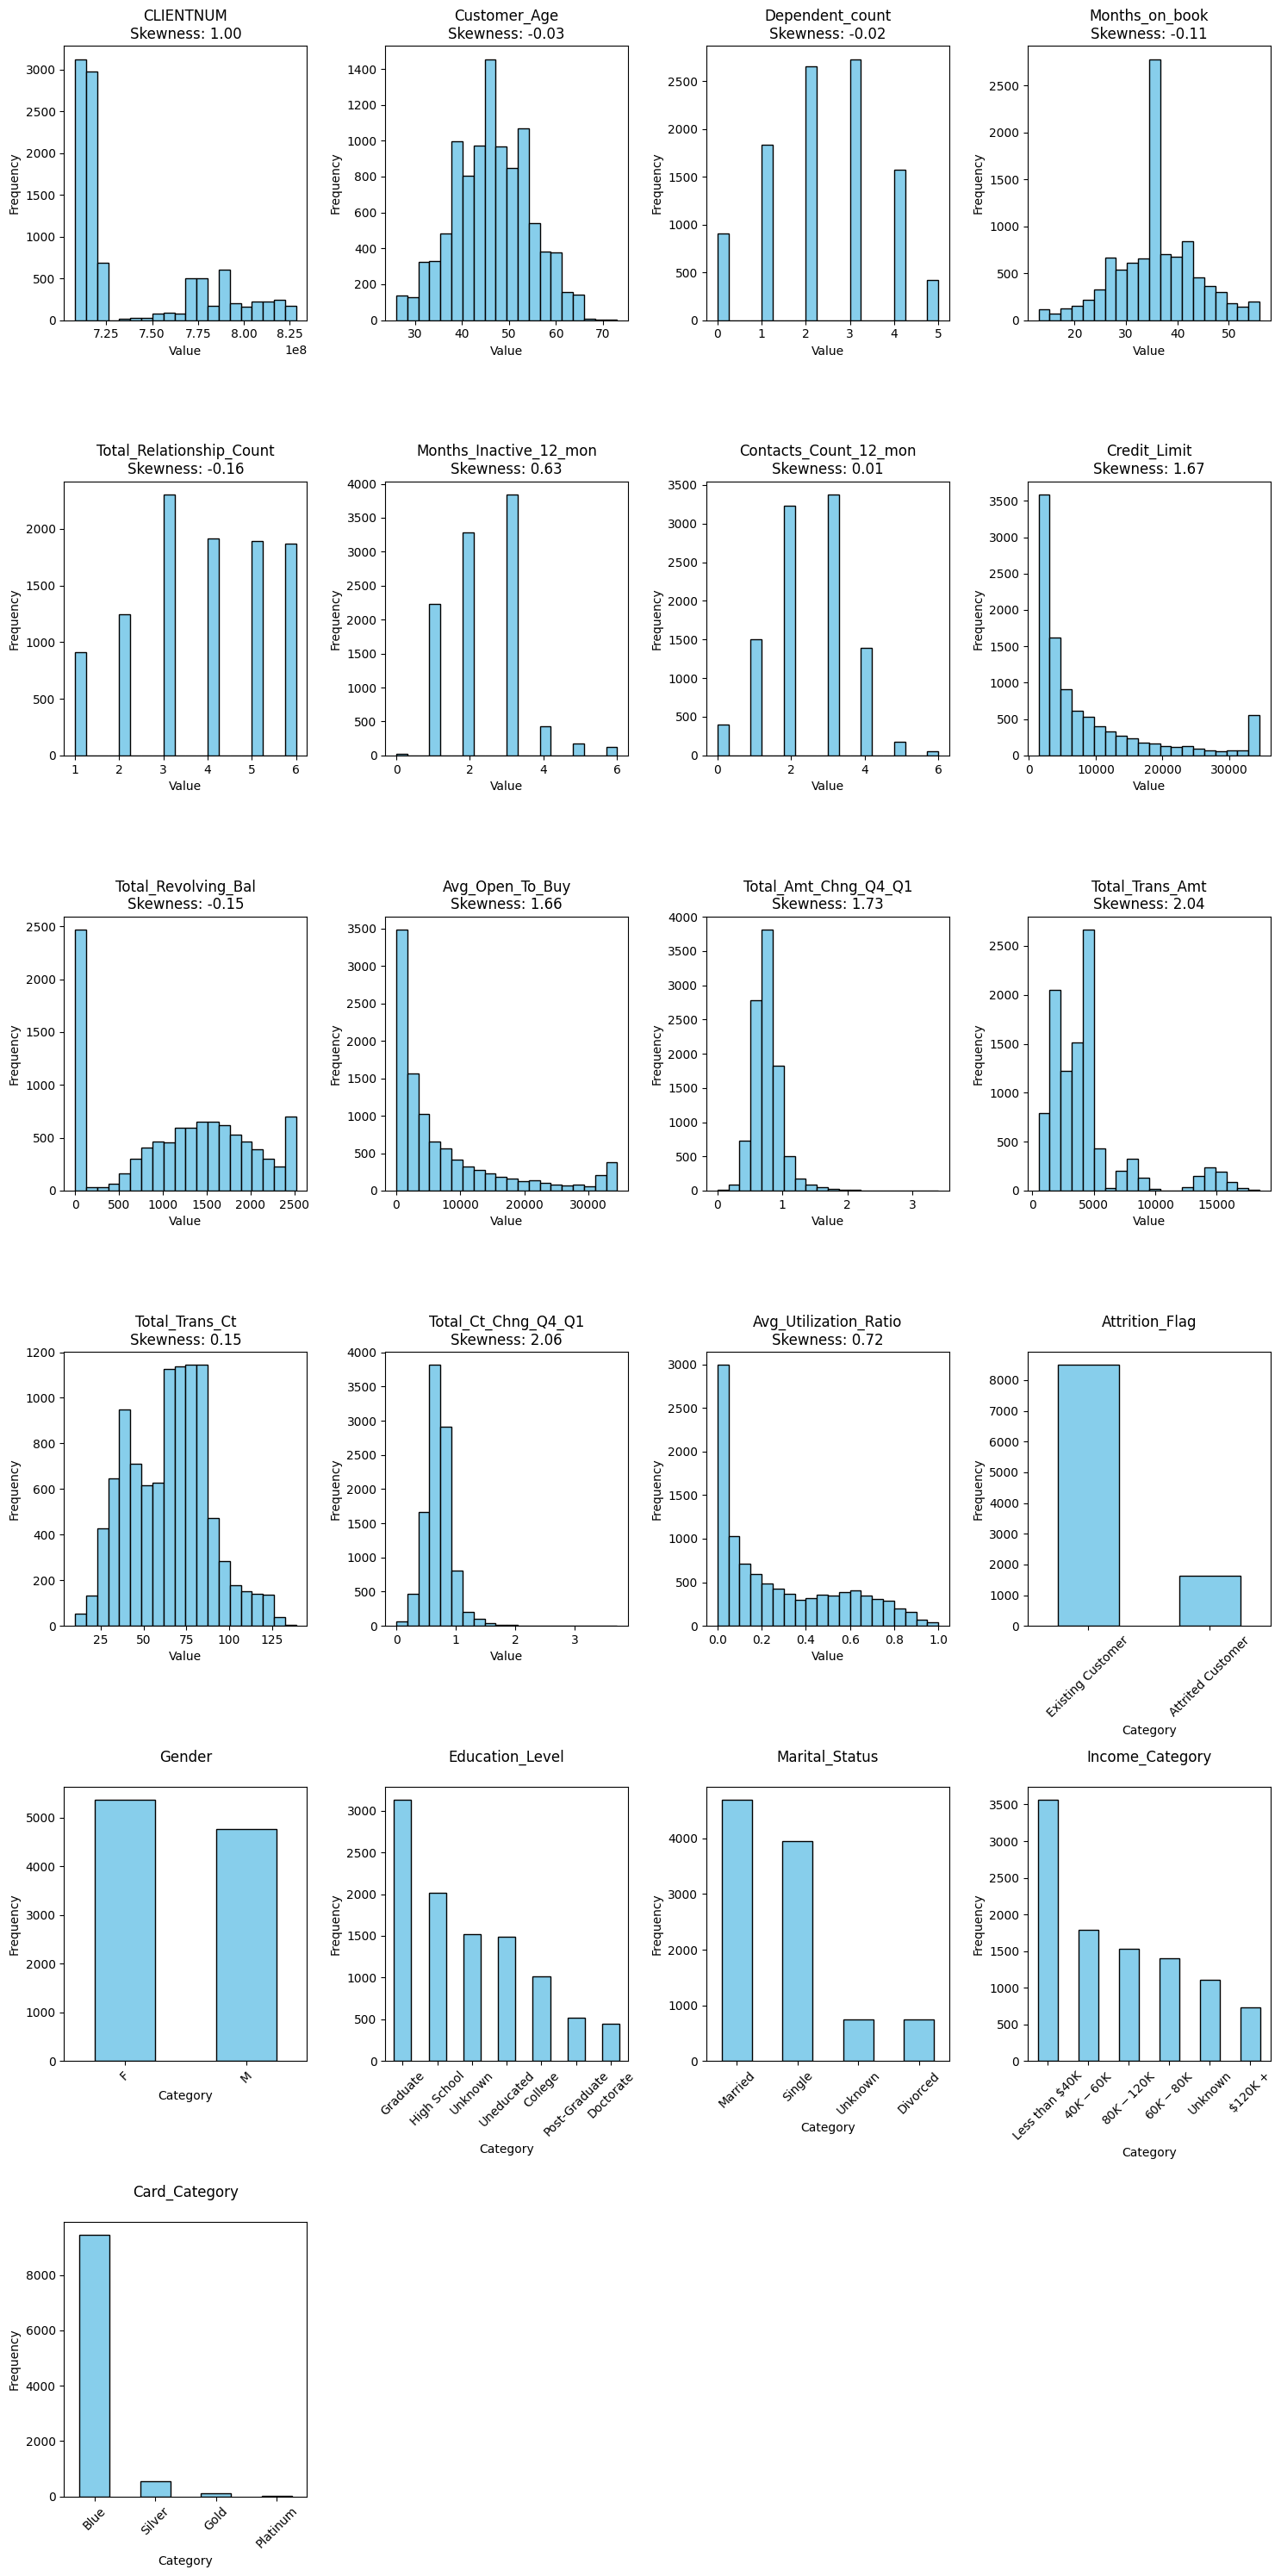

In [4]:
# Create analysis functions
def plot_correlation_matrix(data):
    numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
    corr_matrix = data[numeric_columns].corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

def plot_histograms_with_skewness(data):
    num_columns = len(data.columns)
    num_rows = math.ceil(num_columns / 4)
    plt.figure(figsize=(15, 5 * num_rows))
    numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
    categorical_columns = data.select_dtypes(include=['object']).columns
    
    # Plot histograms for numerical columns
    for i, column in enumerate(numerical_columns):
        plt.subplot(num_rows, 4, i + 1)
        data[column].hist(bins=20, color='skyblue', edgecolor='black')
        plt.title(f"{column}\nSkewness: {data[column].skew():.2f}")
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.grid(False)
    
    # Plot bar plots for categorical columns
    for i, column in enumerate(categorical_columns, start=len(numerical_columns)):
        plt.subplot(num_rows, 4, i + 1)
        data[column].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
        plt.title(f"{column}\n")
        plt.xlabel('Category')
        plt.ylabel('Frequency')
        plt.grid(False)
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

churn_data = churn_data.iloc[:, :-2]

# Plot correlation matrix  and histograms
plot_correlation_matrix(churn_data)
plot_histograms_with_skewness(churn_data)

In [5]:
def print_unique_values(data):
    object_columns = data.select_dtypes(include=['object']).columns
    
    for column in object_columns:
        unique_values = data[column].unique()
        print(f"{column}: {unique_values}")

print_unique_values(churn_data)

Attrition_Flag: ['Existing Customer' 'Attrited Customer']
Gender: ['M' 'F']
Education_Level: ['High School' 'Graduate' 'Uneducated' 'Unknown' 'College' 'Post-Graduate'
 'Doctorate']
Marital_Status: ['Married' 'Single' 'Unknown' 'Divorced']
Income_Category: ['$60K - $80K' 'Less than $40K' '$80K - $120K' '$40K - $60K' '$120K +'
 'Unknown']
Card_Category: ['Blue' 'Gold' 'Silver' 'Platinum']


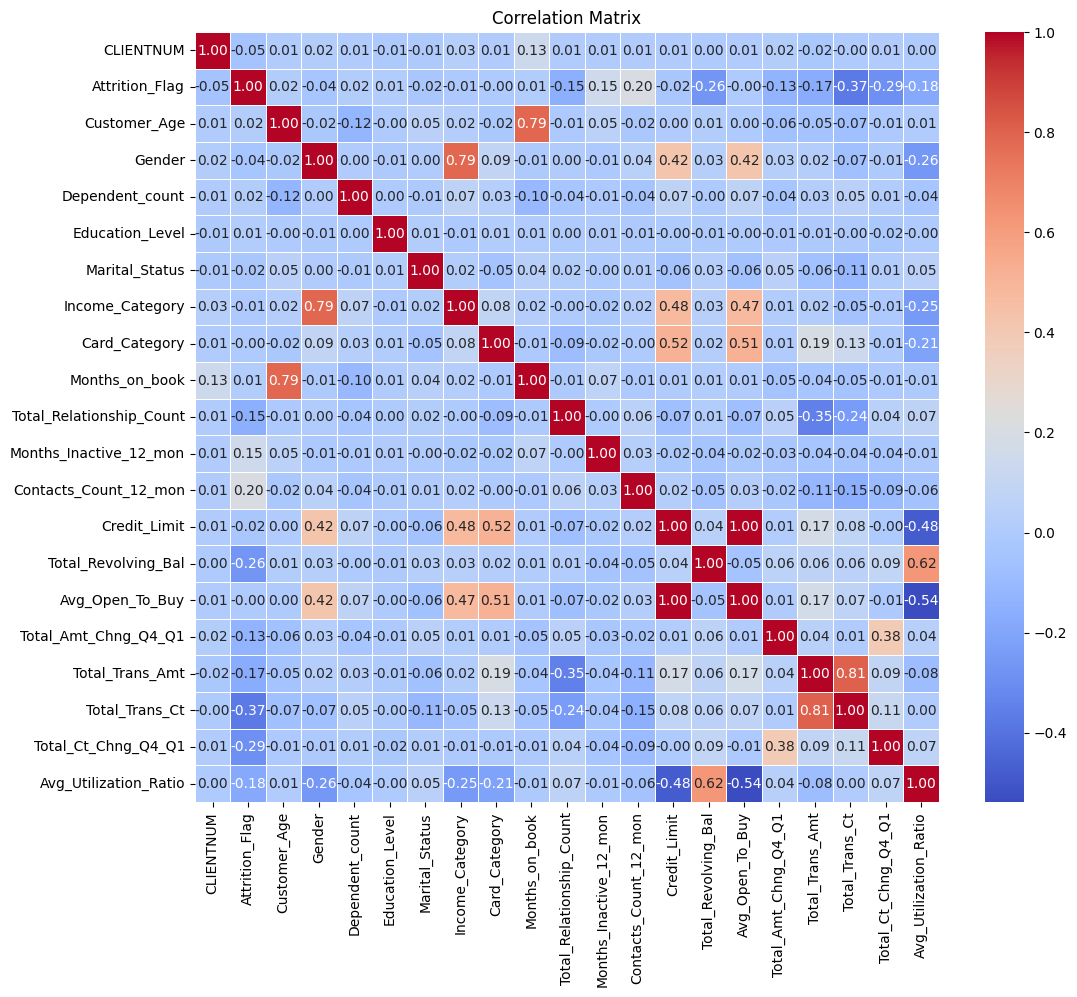

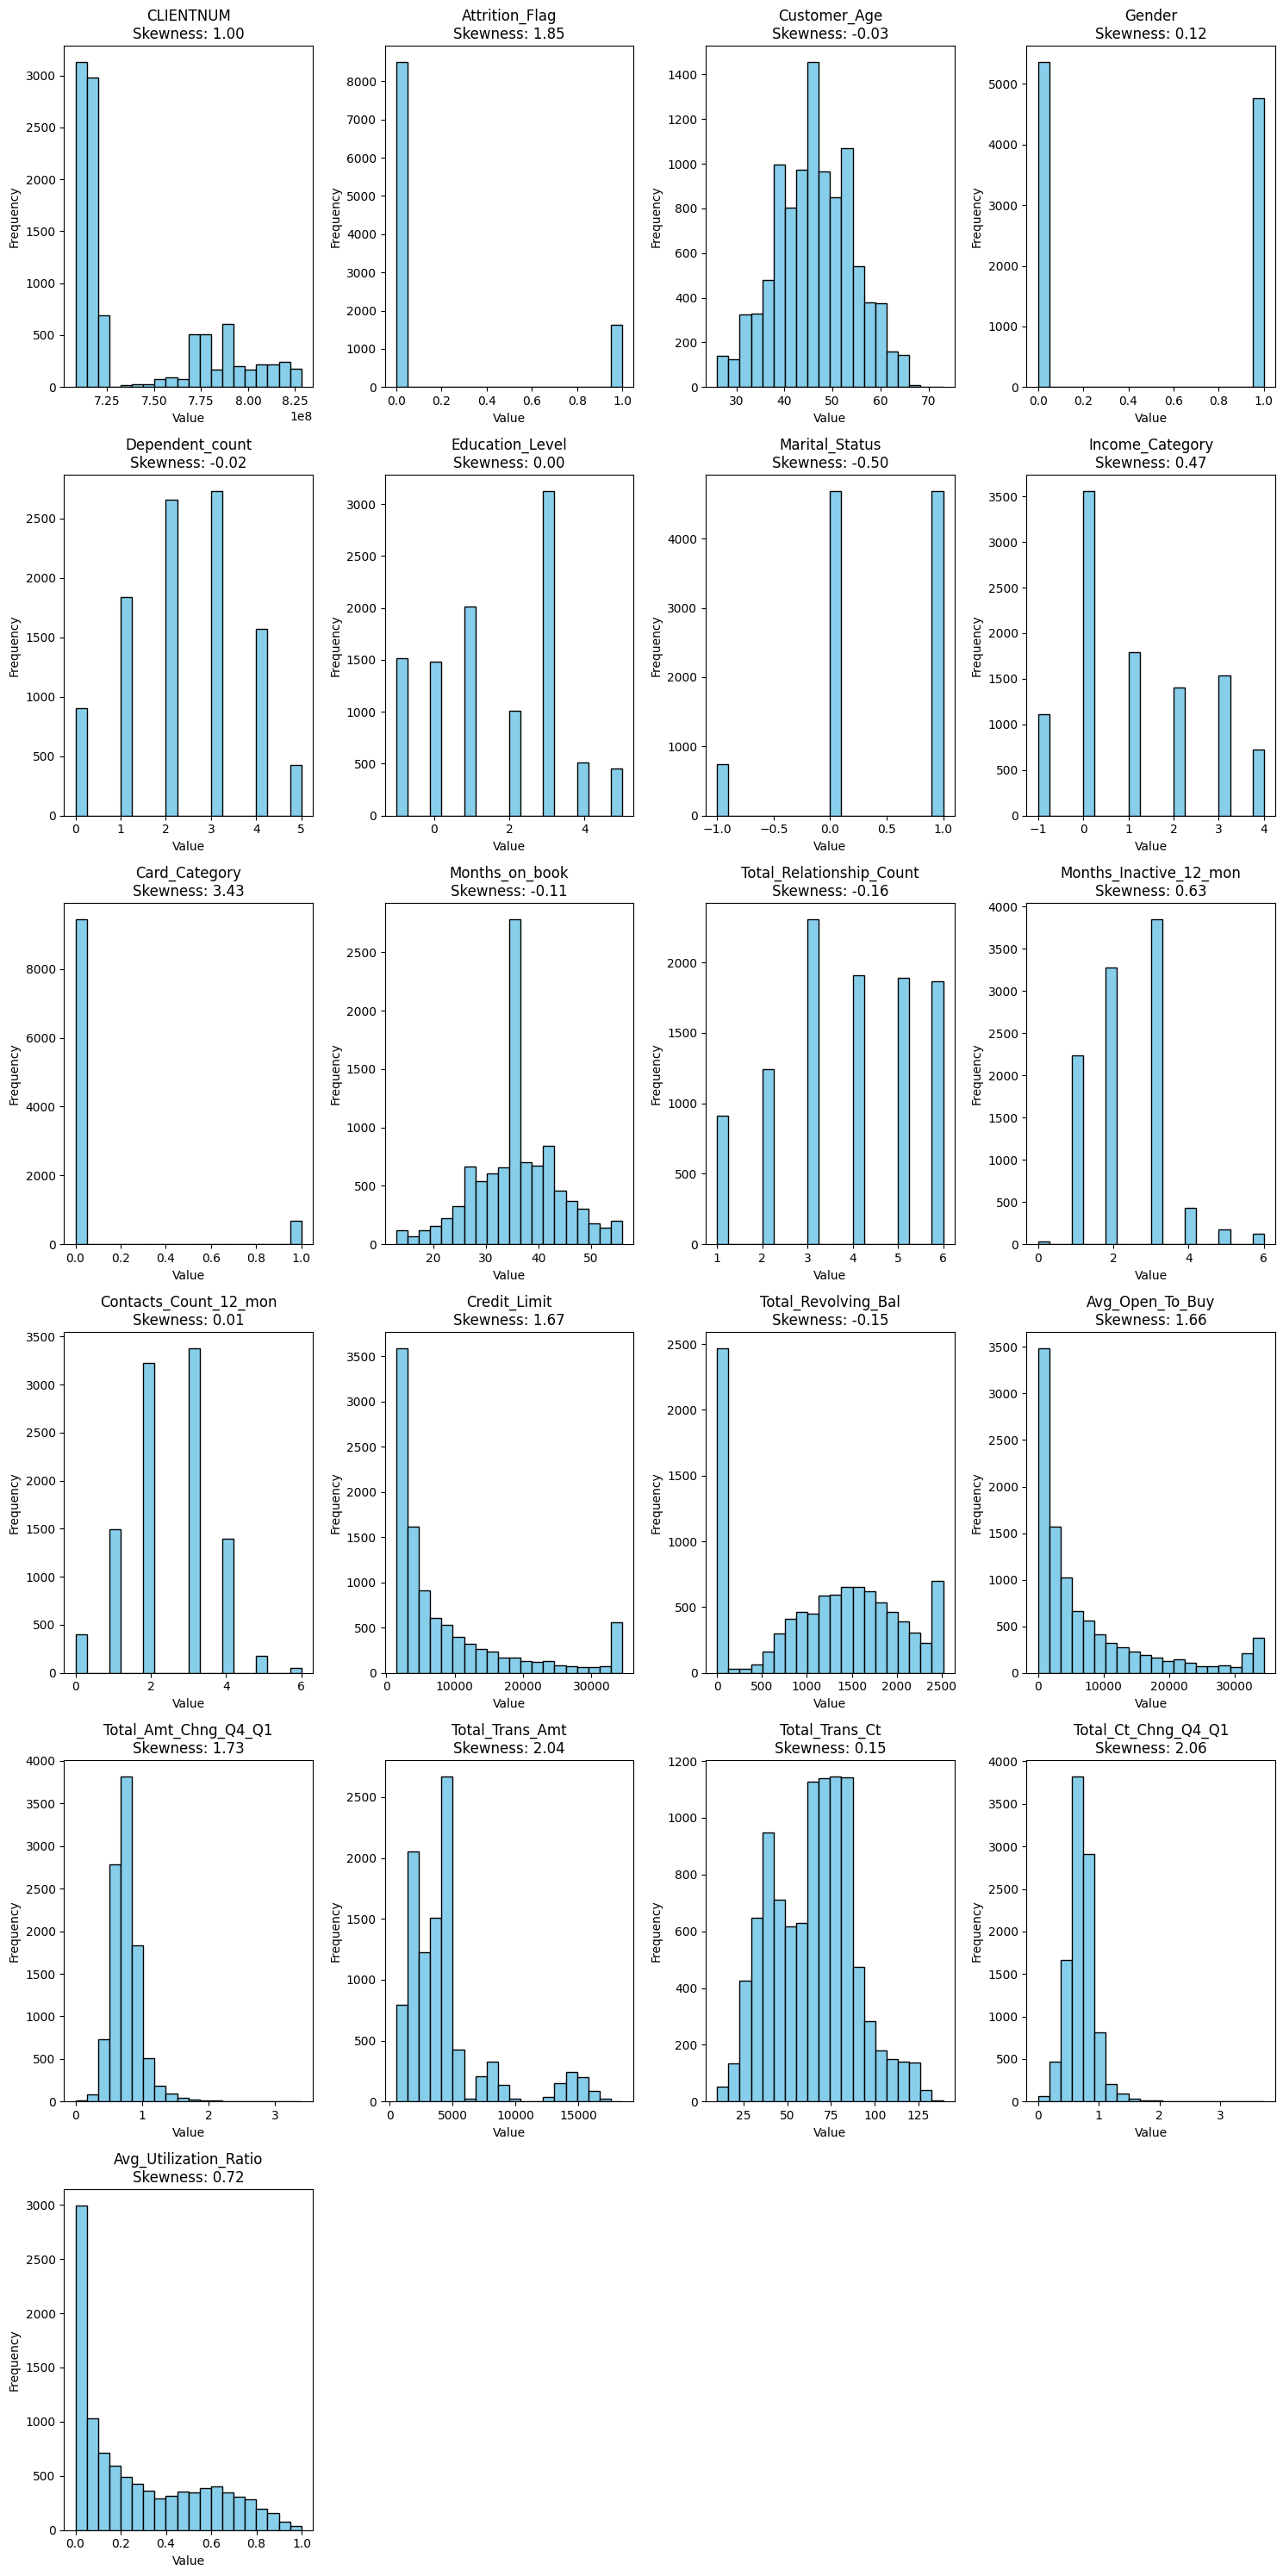

In [6]:
def label_encode_columns(data, encoding_dicts):
    encoded_data = data.copy()
    for column, encoder_dict in encoding_dicts.items():
        encoded_data[column] = encoded_data[column].map(encoder_dict)
    return encoded_data

# Original unique values for object columns
original_unique_values = {
    'Attrition_Flag': ['Existing Customer', 'Attrited Customer'],
    'Gender': ['M', 'F'],
    'Education_Level': ['High School', 'Graduate', 'Uneducated', 'Unknown', 'College', 'Post-Graduate', 'Doctorate'],
    'Marital_Status': ['Married', 'Single', 'Unknown', 'Divorced'],
    'Income_Category': ['$60K - $80K', 'Less than $40K', '$80K - $120K', '$40K - $60K', '$120K +', 'Unknown'],
    'Card_Category': ['Blue', 'Gold', 'Silver', 'Platinum']
}

# Encoding dictionaries
encoding_dicts = {
    'Attrition_Flag': {'Existing Customer': 0, 'Attrited Customer': 1},
    'Gender': {'M': 1, 'F': 0},
    'Education_Level': {'High School': 1, 'Graduate': 3, 'Uneducated': 0, 'Unknown': -1, 'College': 2, 'Post-Graduate': 4, 'Doctorate': 5},
    'Marital_Status': {'Married': 1, 'Single': 0, 'Unknown': -1, 'Divorced': 0},
    'Income_Category': {'$60K - $80K': 2, 'Less than $40K': 0, '$80K - $120K': 3, '$40K - $60K': 1, '$120K +': 4, 'Unknown': -1},
    'Card_Category': {'Blue': 0, 'Gold': 1, 'Silver': 1, 'Platinum': 1}
}

# Apply label encoding
encoded_data = label_encode_columns(churn_data, encoding_dicts)

# Plot correlation matrix for numeric columns
plot_correlation_matrix(encoded_data)
plot_histograms_with_skewness(encoded_data)

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1699
           1       0.93      0.79      0.85       327

    accuracy                           0.96      2026
   macro avg       0.94      0.89      0.91      2026
weighted avg       0.96      0.96      0.96      2026



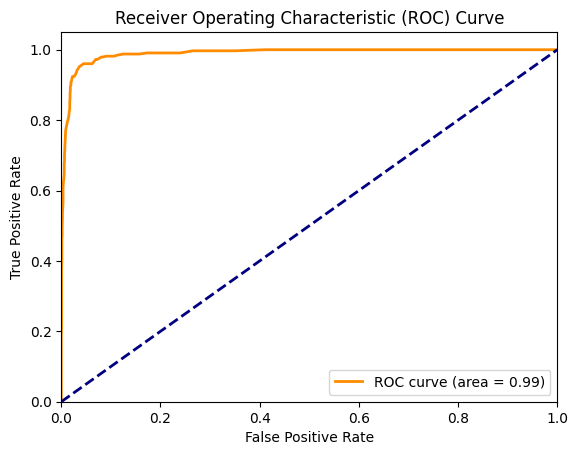

In [7]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc

def random_forest_classifier(data):
    # Import the churn_data dataset
    data = label_encode_columns(data, encoding_dicts)

    # Split the data into features and target variable
    X = data.drop(columns=['Attrition_Flag'])
    y = data['Attrition_Flag']

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train a Random Forest classifier
    classifier = RandomForestClassifier(random_state=42)
    classifier.fit(X_train, y_train)

    # Evaluate the model on test data
    y_pred = classifier.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Plot ROC curve
    y_pred_proba = classifier.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

random_forest_classifier(churn_data)

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file containing the performance data
event_log = pd.read_csv('../files/modeling_event_log.csv')
event_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Execution_Date  50 non-null     object 
 1   Model           50 non-null     object 
 2   Run_Time        50 non-null     float64
 3   Precision       50 non-null     float64
 4   Recall          50 non-null     float64
 5   F1_Score        50 non-null     float64
 6   Accuracy        50 non-null     float64
 7   ROC_AUC         50 non-null     float64
dtypes: float64(6), object(2)
memory usage: 3.3+ KB


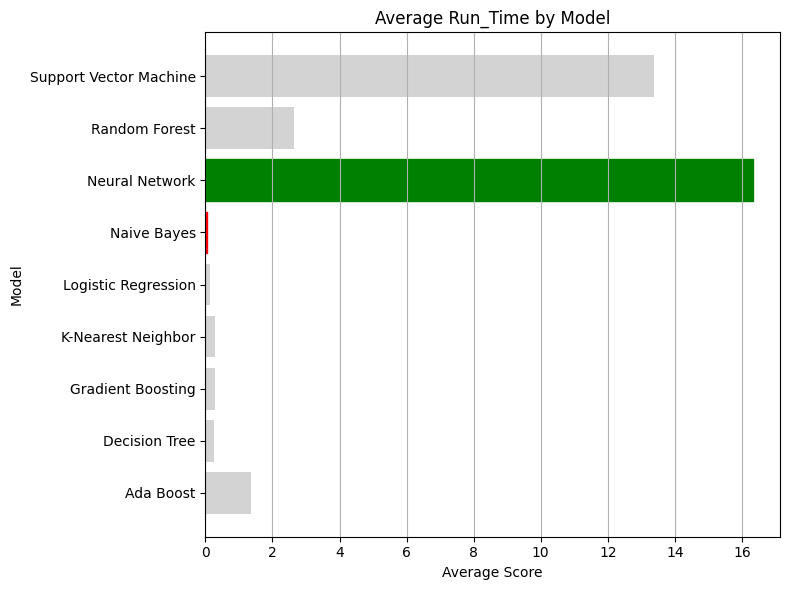

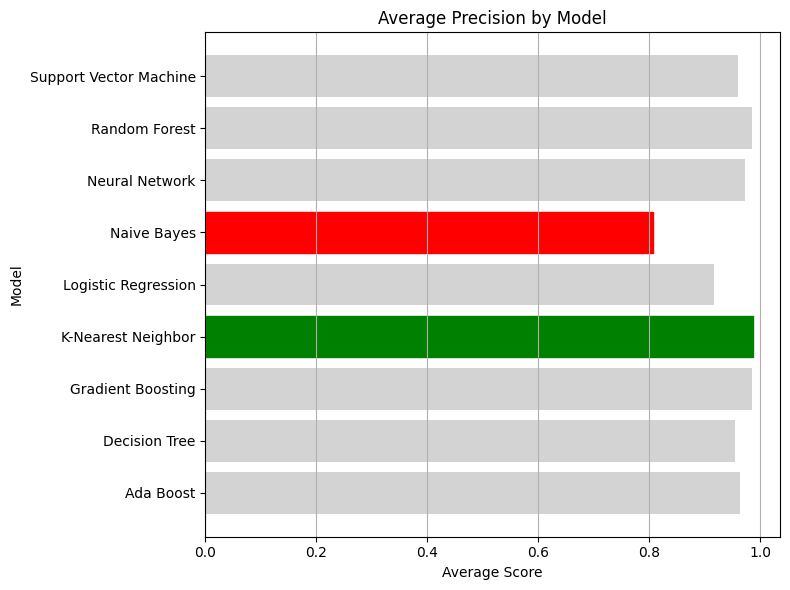

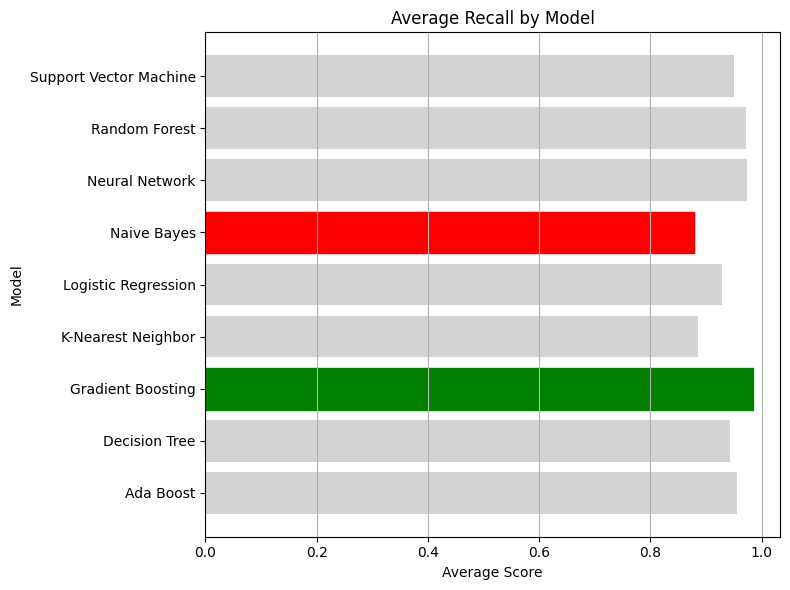

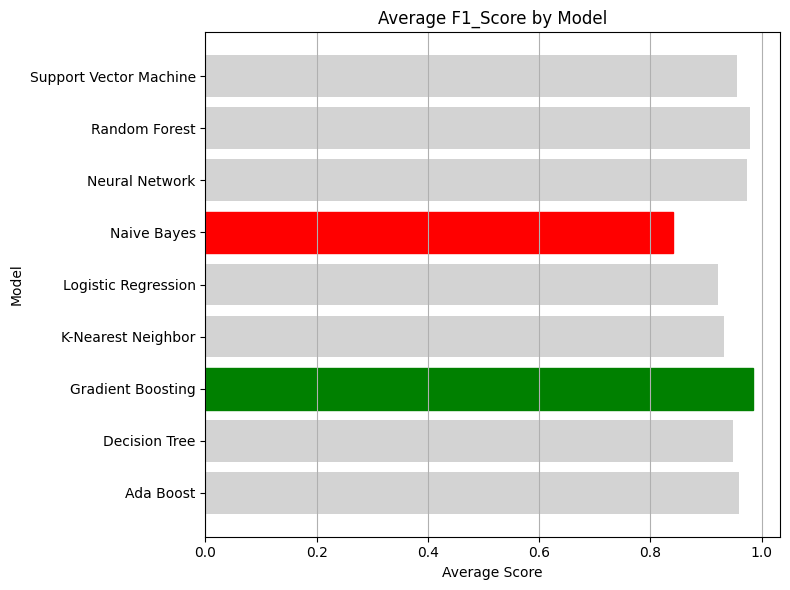

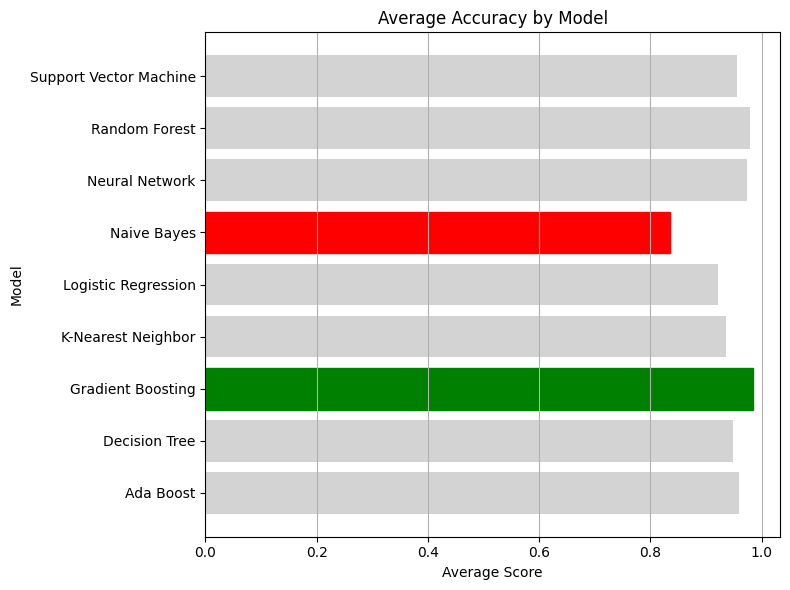

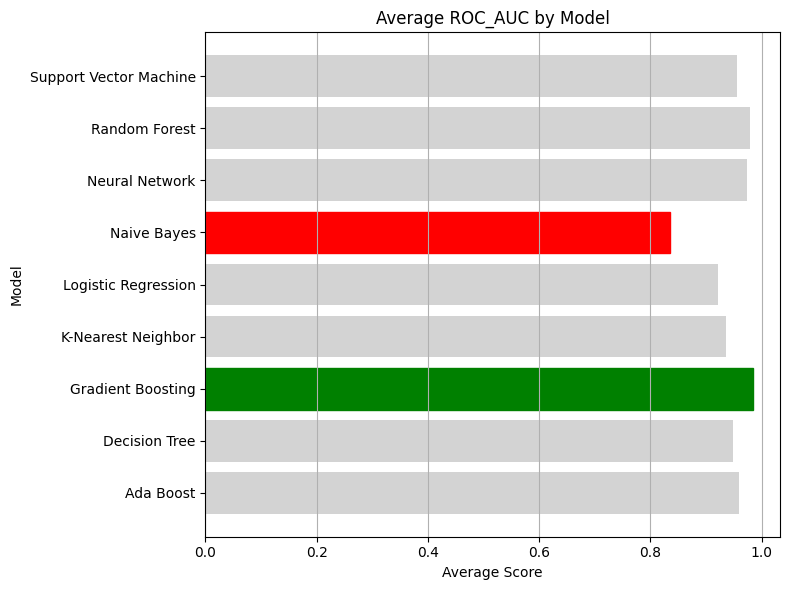

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Define numeric columns
numeric_columns = ['Run_Time', 'Precision', 'Recall', 'F1_Score', 'Accuracy', 'ROC_AUC']

# Group by model and calculate the mean of numeric columns
model_performance = event_log.groupby('Model')[numeric_columns].mean()

# Sort models alphabetically
model_performance = model_performance.sort_index()

# Defining colors
colors = ['lightgray', 'green', 'red']  # Light gray for average, green for best, red for worst

# Plotting each column separately
for column in numeric_columns:
    plt.figure(figsize=(8, 6))
    bars = plt.barh(model_performance.index, model_performance[column], color=colors[0])  # Start with light gray
    
    # Find index of best and worst values
    best_index = model_performance[column].idxmax()
    worst_index = model_performance[column].idxmin()
    
    # Color the bars for best and worst values
    bars[model_performance.index.get_loc(best_index)].set_color(colors[1])  # Green for best
    bars[model_performance.index.get_loc(worst_index)].set_color(colors[2])  # Red for worst
    
    plt.xlabel('Average Score')
    plt.ylabel('Model')
    plt.title(f'Average {column} by Model')
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

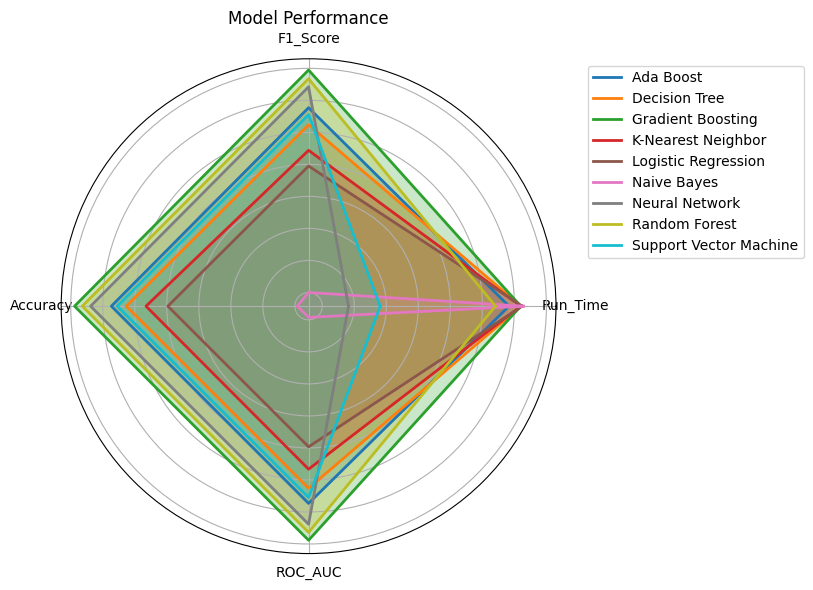

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

# Define numeric columns
numeric_columns = ['Run_Time', 'F1_Score', 'Accuracy', 'ROC_AUC']

# Group by model and calculate the mean of numeric columns
model_performance = event_log.groupby('Model')[numeric_columns].mean()

# Invert the run time values
model_performance['Run_Time'] *= -1

# Standard scale the data
scaler = StandardScaler()
model_performance_scaled = scaler.fit_transform(model_performance)

# Define colors for each model
colors = plt.cm.tab10(np.linspace(0, 1, len(model_performance)))

# Plotting spider chart
plt.figure(figsize=(8, 6))
for i, model in enumerate(model_performance_scaled):
    # Calculate angles for each axis
    angles = np.linspace(0, 2 * np.pi, len(numeric_columns), endpoint=False).tolist()
    angles += angles[:1]  # Close the plot

    # Adjust model array to match dimensions of angles array
    model = np.concatenate((model, [model[0]]))  # Add first element to the end to close the plot

    # Plot each axis of the radar chart
    ax = plt.subplot(111, polar=True)
    ax.fill(angles, model, color=colors[i], alpha=0.25)
    ax.plot(angles, model, color=colors[i], linewidth=2, label=model_performance.index[i])
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(numeric_columns)
    ax.yaxis.grid(True)

plt.title('Model Performance')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()
